# Tabularize time series

In this assignment, your task is to convert **time series data** into a **tabular data set**.

You need to create suitable input features from a time series containing weekly sales to be able to forecast sales for the next week.

To prepare the dataset for this assignment, please follow the guidelines in the notebook `02-create-online-retail-II-datasets.ipynb` in the `01-Create-Datasets` folder.

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error as mse
from typing import Union

In [2]:

# load weekly sales dataset

filename = "../Datasets/online_retail_dataset.csv"

df = pd.read_csv(
    filename,
    usecols=["week", "United Kingdom"],
    parse_dates=["week"],
    index_col=["week"],
)

df.columns = ['sales']

df.head()

,sales
week,
2009-12-06,213000.35
2009-12-13,195810.04
2009-12-20,182396.74
2009-12-27,22007.77
2010-01-03,0.00


# Data analysis

First, explore the time series.

## Plot time series

<AxesSubplot: xlabel='week'>

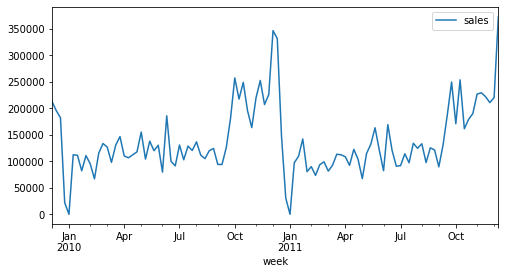

In [3]:
fig, ax=plt.subplots(figsize=(8,4))
df.plot(ax=ax)

## Missing data

Check if there are missing values in the time series.

In [4]:
df.isnull().sum()

sales    0
dtype: int64

## Missing timestamps

Check if there are missing timestamps in the index.

In [7]:
df.index

DatetimeIndex(['2009-12-06', '2009-12-13', '2009-12-20', '2009-12-27',
               '2010-01-03', '2010-01-10', '2010-01-17', '2010-01-24',
               '2010-01-31', '2010-02-07',
               ...
               '2011-10-09', '2011-10-16', '2011-10-23', '2011-10-30',
               '2011-11-06', '2011-11-13', '2011-11-20', '2011-11-27',
               '2011-12-04', '2011-12-11'],
              dtype='datetime64[ns]', name='week', length=106, freq=None)

In [7]:
idx=pd.date_range(start='2009-12-06', end='2011-12-11', freq='7D')
idx.difference(df.index)

DatetimeIndex([], dtype='datetime64[ns]', freq='7D')

so there are not missing timestamps

## Seasonality

Does the time series show any obvious seasonal pattern?

sales                            
year         2009          2010          2011
month                                        
1             NaN   83327.04840   85886.12800
2             NaN  102769.48400   89035.23000
3             NaN  125529.53025   99943.92250
4             NaN  111697.03500  106950.89275
5             NaN  129545.52220  119728.78600
6             NaN  114235.32000  115756.06500
7             NaN  120675.62500  112376.19220
8             NaN  119516.69400  119418.22500
9             NaN  123674.78525  164559.86025
10            NaN  216586.94000  191039.31020
11            NaN  226303.62300  222190.14750
12     153303.725  213945.07000  296580.12500

<AxesSubplot: xlabel='month'>

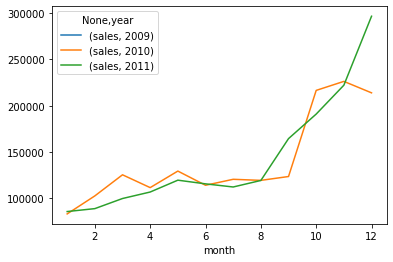

In [13]:
df_cp=df.copy()
df_cp['year']=df_cp.index.year
df_cp['month']=df_cp.index.month
display(df_cp.groupby(['year','month']).mean().unstack('year'))
df_cp.groupby(['year','month']).mean().unstack('year').plot()

no obvious seasonality

# Feature engineering

Now, let's begin to tabularize the data.

## Split data

Separate the data into training and testing sets, leaving the data after the last week of September to evaluate the forecasts, that is, in the testing set.

In [23]:
train_df=df.loc[:f'{df.index[-1].year}-10-01']
test_df=df.loc[f'{df.index[-1].year}-10-01':]
print(f"Nb data: {len(df)} - Nb train: {len(train_df)} - Nb test: {len(test_df)}")

Nb data: 106 - Nb train: 95 - Nb test: 11


## Naive forecast

Predict sales in the next week (t) as the value of sales in the previous week (t-1).

In [24]:
naive_forecast_df=df.shift(1).loc[f'{df.index[-1].year}-10-01':].rename(
    columns={col:f'{col}_nf' for col in df.columns}) 
pred_df=pd.concat([test_df,naive_forecast_df], axis=1)
display(pred_df)

,sales,sales_nf
week,,
2011-10-02,170904.201,249563.051
2011-10-09,253713.540,170904.201
2011-10-16,161438.540,253713.540
2011-10-23,179106.070,161438.540
2011-10-30,190034.200,179106.070
2011-11-06,226770.530,190034.200
2011-11-13,229378.010,226770.530
2011-11-20,221870.290,229378.010
2011-11-27,210741.760,221870.290


## Machine Learning

In [42]:
%%time
class CreateFeatures(TransformerMixin, BaseEstimator):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X:Union[pd.Series, pd.DataFrame]):
        return pd.DataFrame({'year':X.index.year,
                'month':X.index.month, 'quarter':X.index.quarter
                            })
    
linearRegression_model=Pipeline(steps=[
    ('CreateFeatures', CreateFeatures()),
    ('PolynomialFeatures',PolynomialFeatures(3)),
    ('standardScaler',StandardScaler()),
    ('linearRegression',LinearRegression())
])
linearRegression_model.fit(train_df, train_df['sales'])

Wall time: 13 ms


Pipeline(steps=[('CreateFeatures', CreateFeatures()),
                ('PolynomialFeatures', PolynomialFeatures(degree=3)),
                ('standardScaler', StandardScaler()),
                ('linearRegression', LinearRegression())])

In [43]:
lr_forecast_df=pd.DataFrame(linearRegression_model.predict(test_df), 
                         columns=['sales_lr'], index=test_df.index)
display(lr_forecast_df)

,sales_lr
week,
2011-10-02,206632.20128
2011-10-09,206632.20128
2011-10-16,206632.20128
2011-10-23,206632.20128
2011-10-30,206632.20128
2011-11-06,249064.20128
2011-11-13,249064.20128
2011-11-20,249064.20128
2011-11-27,249064.20128


In [44]:
pred_df['sales_lr']=lr_forecast_df['sales_lr']
#pred_df=pd.concat([pred_df,lr_forecast_df], axis=1)
display(pred_df)

,sales,sales_nf,sales_lr
week,,,
2011-10-02,170904.201,249563.051,206632.20128
2011-10-09,253713.540,170904.201,206632.20128
2011-10-16,161438.540,253713.540,206632.20128
2011-10-23,179106.070,161438.540,206632.20128
2011-10-30,190034.200,179106.070,206632.20128
2011-11-06,226770.530,190034.200,249064.20128
2011-11-13,229378.010,226770.530,249064.20128
2011-11-20,221870.290,229378.010,249064.20128
2011-11-27,210741.760,221870.290,249064.20128


<AxesSubplot: xlabel='week'>

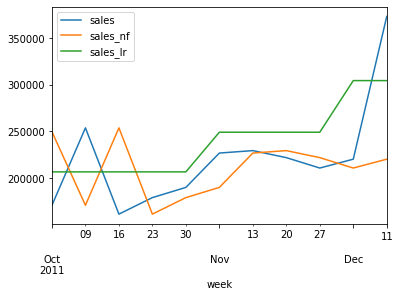

In [45]:
pred_df.plot()

[Text(0, 0, '65327.34'), Text(0, 0, '44152.74')]

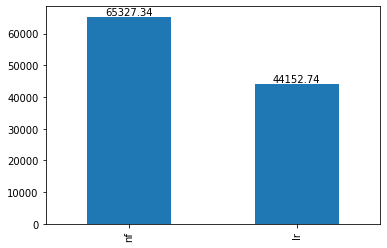

In [52]:
methods=['nf', 'lr']
pred_mse_dict={method:mse(pred_df['sales'], pred_df[f'sales_{method}'], squared=False) \
               for method in methods
              }
pred_mse_sr=pd.Series(pred_mse_dict)
ax=pred_mse_sr.plot.bar()
ax.bar_label(ax.containers[0], fmt='%3.2f')